## ASF Core Data Infrastructure -  Data Loaders

This notebook shows how to load and use the EPC data and related datasets. <br>
The data can be loaded directly from the S3 bucket named [`asf-core-data`](https://s3.console.aws.amazon.com/s3/buckets/asf-core-data?region=eu-west-2&tab=objects) or it can be downloaded to a local directory, from where it will be loaded when needed.

In [1]:
%load_ext autoreload
%autoreload 2

import os

from asf_core_data import load_preprocessed_epc_data, PROJECT_DIR
from asf_core_data.config import base_config

from asf_core_data.getters import data_getters
from asf_core_data.getters.epc import epc_data, data_batches
from asf_core_data.getters.supplementary_data.deprivation import imd_data
from asf_core_data.getters.supplementary_data.geospatial import coordinates

from asf_core_data.pipeline.preprocessing import preprocess_epc_data
from asf_core_data.pipeline.preprocessing import feature_engineering, data_cleaning
from asf_core_data.pipeline.data_joining import install_date_computation
from asf_core_data.utils.visualisation import easy_plotting

2023-03-17 10:33:00,516 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2023-03-17 10:33:01,751 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/Users/juliasuter/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/juliasuter/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/juliasuter/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a fut

## Local Data Dir

While all the data can be loaded from S3 directly, some data takes a long time to load. It is easiest to keep a local copy in a designated folder that mirrors the structure of the S3 bucket asf-core-data. 

The setup is easy: create an empty folder of any name in any location you like. The next cell will even create this folder for you if it doesn't already exist.

The keyword argument `data_path` that is passed to many loading functions defines whether the data is loaded from S3 (`"S3"`) or from the local directory (`LOCAL_DATA_DIR`). The advantage of loading from S3 is that you data is always up-to-date. The disadvantage is that reading certain data directly from S3 can take a long time, which would need to be repeated everytime the code is executed. 

We recommend using direct loading from S3 for smaller datasets, such as MCS and supplementary data or smaller subsets of the EPC data, but keep a copy of the large EPC files in a local directory. Functions such as `data_batches.check_for_newest_epc_batch()` will notify you if your local batch is not up-to-date. 

**Note**: the keyword `data_path` will be renamed to `data_source` after the next merge.

`LOCAL_DATA_DIR` needs to be a full path or a relative path to where notebook is executed. 


In [2]:
LOCAL_DATA_DIR = '/path/to/data/dir'

if not os.path.exists(LOCAL_DATA_DIR):
    os.makedirs(LOCAL_DATA_DIR)

If you have just created a new data folder, then before downloading any data, there will be no EPC data batches in your local directory.


In [3]:
print("Local dir\n---------------")
print("Available batches:", data_batches.get_all_batch_names(data_path=LOCAL_DATA_DIR, check_folder='input'))

Local dir
---------------
Available batches: []


## Download some of the data to your local dir

Our current data dir is still empty at this point. The function `print_download_options()` shows us what data can be downloaded from S3. The option of downloading MCS data will be added shortly.

We download the raw EPC data for England, Wales and Scotland for the batch `2021_Q2_0721`. We also download the raw and the preprocessed + deduplicated EPC data of the newest batch.

In [4]:
data_getters.print_download_options()

epc_raw
epc_raw_combined
epc_preprocessed_dedupl
epc_preprocessed
EST_cleansed
EST_cleansed_dedupl
supplementary_data


In [5]:
%%time
data_getters.download_core_data('epc_raw', LOCAL_DATA_DIR, batch='2021_Q2_0721')

CPU times: user 2min 12s, sys: 30.4 s, total: 2min 43s
Wall time: 7min 5s


In [6]:
%%time
data_getters.download_core_data('epc_raw_combined', LOCAL_DATA_DIR, batch="newest")

CPU times: user 50.4 s, sys: 7.9 s, total: 58.3 s
Wall time: 2min 8s


In [7]:
%%time
data_getters.download_core_data('epc_preprocessed_dedupl', LOCAL_DATA_DIR, batch="newest")

CPU times: user 45 s, sys: 11 s, total: 56 s
Wall time: 2min 24s


## Batch checking

When working with local data, it is important to keep track of the batches and keep your data up-to-date. The first output shows that our input directory is not up-to-date but our output directory is. (Note that we didn't download the same batch for the raw and preprocessed data above.)

After downloading the most recent data batch for the raw EPC data, we get confirmation that our data is now up-to-date. The batch checking functions show that our local input directory now contains two batches and the output directory contains only one batch.

The most recent batch will always contain all the EPC data available to us (including previous batches), so the number of samples will naturally increase with every batch. The number of features may also change as new fields are added, although this may not happen with every new batch.

In [8]:
data_batches.check_for_newest_batch(data_path=LOCAL_DATA_DIR, check_folder='inputs', verbose=True)

With batch 2021_Q2_0721 your local data is not up to date. The newest batch 2022_Q3_complete is available on S3.


(False, '2022_Q3_complete')

In [9]:
data_batches.check_for_newest_batch(data_path=LOCAL_DATA_DIR, check_folder='outputs', verbose=True)

Your local data is up to date with batch 2022_Q3_complete


(True, '2022_Q3_complete')

In [11]:
data_getters.download_core_data('epc_raw', LOCAL_DATA_DIR, batch="newest")

In [12]:
data_batches.check_for_newest_batch(data_path=LOCAL_DATA_DIR, check_folder='inputs', verbose=True)

Your local data is up to date with batch 2022_Q3_complete


(True, '2022_Q3_complete')

In [13]:
print("S3 bucket\n---------------")
print("Available batches:", data_batches.get_all_batch_names(data_path="S3"))
print("Newest batch:", data_batches.get_most_recent_epc_batch(data_path="S3"))

S3 bucket
---------------
Available batches: ['2021_Q2_0721', '2021_Q4_0721', '2022_Q1_complete', '2022_Q3_complete']
Newest batch: 2022_Q3_complete


In [14]:
print("Local input dir\n---------------")
print("Available batches:", data_batches.get_all_batch_names(data_path=LOCAL_DATA_DIR, check_folder='inputs'))
print("Newest batch:", data_batches.get_most_recent_epc_batch(data_path=LOCAL_DATA_DIR))

Local input dir
---------------
Available batches: ['2021_Q2_0721', '2022_Q3_complete']
Newest batch: 2022_Q3_complete


In [15]:
print("Local output dir\n---------------")
print("Available batches:", data_batches.get_all_batch_names(data_path=LOCAL_DATA_DIR, check_folder='outputs'))
print("Newest batch:", data_batches.get_most_recent_epc_batch(data_path=LOCAL_DATA_DIR))

Local output dir
---------------
Available batches: ['2022_Q3_complete']
Newest batch: 2022_Q3_complete


In [18]:
wales_epc = epc_data.load_raw_epc_data(
    data_path=LOCAL_DATA_DIR, subset="Wales", batch="2021_Q2_0721"
)
print(
    "Batch 2021_Q2_0721 includes {} samples and {} features.".format(
        wales_epc.shape[0], wales_epc.shape[1]
    )
)

Batch 2021_Q2_0721 includes 1111383 samples and 92 features.


In [19]:
wales_epc = epc_data.load_raw_epc_data(
    data_path=LOCAL_DATA_DIR, subset="Wales", batch="newest"
)
print(
    "The newest batch includes {} samples and {} features.".format(
        wales_epc.shape[0], wales_epc.shape[1]
    )
)

The newest batch includes 1214950 samples and 93 features.


## Loading raw EPC data

### Loading from local dir


Load different subsets and batches of raw EPC data from the local data dir. Wales and Scotland subsets can easily be loaded, but England or GB take more than 10min.

In [20]:
wales_epc = epc_data.load_raw_epc_data(
    data_path=LOCAL_DATA_DIR, subset="Wales", batch="newest"
)
wales_epc.shape

(1214950, 93)

In [21]:
wales_recs = epc_data.load_raw_epc_data(data_path=LOCAL_DATA_DIR, subset='Wales', load_recs=True)
print(wales_recs.shape)
wales_recs.columns


(5654219, 8)


Index(['LMK_KEY', 'IMPROVEMENT_ITEM', 'IMPROVEMENT_SUMMARY_TEXT',
       'IMPROVEMENT_DESCR_TEXT', 'IMPROVEMENT_ID', 'IMPROVEMENT_ID_TEXT',
       'INDICATIVE_COST', 'COUNTRY'],
      dtype='object')

In [22]:
scotland_epc = epc_data.load_raw_epc_data(
    data_path=LOCAL_DATA_DIR, subset="Scotland", batch="newest"
)
scotland_epc.shape

(1596414, 105)

### Loading directly from S3

This works, but it can take a while and is not recommended for frequent use.

Loading the Wales EPC data can take up to 5min. <br>
Loading the Scotland EPC data can take up to 10min. <br>
Loading the England EPC data can take up to 30min. <br>
Loading the entire GB EPC data takes even longer... <br>

It is recommended to download the data and read the data from a local directory instead, especially if needed more than just once.

In [23]:
# # Commented out to reduce runtime

# england_epc = epc_data.load_raw_epc_data(
#     data_path=LOCAL_DATA_DIR, subset="England", batch="newest"
# )
# england_epc.shape

In [24]:
# # Commented out to reduce runtime

# %%time
# epc_data.load_raw_epc_data(
#     data_path="S3", subset="Wales")

In [25]:
# #Commented out to reduce runtime

# %%time
# epc_data.load_raw_epc_data(
#     data_path="S3", subset="Scotland")

In [26]:
# # Commented out to reduce runtime

# %%time
# epc_data.load_raw_epc_data(
#     data_path="S3", subset="England")

In [27]:
# # Commented out to reduce runtime

# %%time
# epc_data.load_raw_epc_data(
#     data_path="S3", subset="GB")

## Load preprocessed EPC data

### Loading from local dir

In [28]:
prep_epc = load_preprocessed_epc_data(
    data_path=LOCAL_DATA_DIR,
    usecols=['CURRENT_ENERGY_RATING', 'PROPERTY_TYPE', 'BUILT_FORM', 'CONSTRUCTION_AGE_BAND', 'COUNTRY'],
    version="preprocessed_dedupl", subset='Wales'
)

prep_epc.shape

(907997, 5)

In [29]:
prep_epc_dedupl = load_preprocessed_epc_data(data_path=LOCAL_DATA_DIR, version='preprocessed_dedupl',
                                          usecols=base_config.EPC_PREPROC_FEAT_SELECTION, batch='newest',
                                          n_samples=5000
                                         )

prep_epc_dedupl.shape

(5000, 57)

In [30]:
prep_epc_dedupl = load_preprocessed_epc_data(data_path=LOCAL_DATA_DIR, version='preprocessed_dedupl',
                                          usecols=['CURRENT_ENERGY_EFFICIENCY', 'PROPERTY_TYPE', 'BUILT_FORM', 'CONSTRUCTION_AGE_BAND', 'COUNTRY'],
                                              
                                         )

prep_epc_dedupl.shape

(19049475, 5)

### Loading data from directly from S3

In [31]:
prep_epc = load_preprocessed_epc_data(data_path="S3", version='preprocessed_dedupl',
                                          usecols=['UPRN', 'CURRENT_ENERGY_RATING', 'INSPECTION_DATE',
                                                   'PROPERTY_TYPE', 'CONSTRUCTION_AGE_BAND'],
                                          batch='newest',
                                          n_samples=50000)

prep_epc.shape

2023-03-17 11:08:38,987 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


(50000, 5)

Pro tip: you can filter the data by entry year.

In [32]:
prep_epc_2015 = epc_data.filter_by_year(prep_epc, 2018, up_to=True)
sorted(prep_epc_2015["INSPECTION_DATE"].dt.year.unique())

[2014, 2016, 2017, 2018]

### Preprocess the data

As preprocessed versions are available on S3 for each batch, this functionionality is optional. Preprocessing can be repeated when the preprocessing pipeline has been updated or if further fields are added.

`load_and_preprocess_epc_data()` loads the relevant EPC data, cleans it and adds additonal features.

In [33]:
wales_epc_reduced = preprocess_epc_data.load_and_preprocess_epc_data(
    data_path=LOCAL_DATA_DIR, batch="newest", subset='Wales', 
    reload_raw=False
)

2023-03-17 11:08:42,338 - root - WARNING - Careful! You're not loading the complete GB dataset.
Saving raw data to /Users/juliasuter/Documents/New_data/outputs/EPC/preprocessed_data/2022_Q3_complete/EPC_Wales_raw.csv

Saving preprocessed data to /Users/juliasuter/Documents/New_data/outputs/EPC/preprocessed_data/2022_Q3_complete/EPC_Wales_preprocessed.csv

Saving preprocessed and deduplicated data to /Users/juliasuter/Documents/New_data/outputs/EPC/preprocessed_data/2022_Q3_complete/EPC_Wales_preprocessed_and_deduplicated.csv

Original data:	1214950 samples, 49 features
After cleaning:	1214950 samples, 56 features
After adding features:	1214950 samples, 65 features
After removing duplicates:	908445 samples, 65 features


You can also get more accurate estimates for the heat pump installation date by integrating MCS data.

In [34]:
wales_epc_with_MCS_dates = install_date_computation.compute_hp_install_date(
    wales_epc_reduced
)
wales_epc_with_MCS_dates.head()

/Users/juliasuter/Documents/repositories/asf_core_data/asf_core_data/pipeline/data_joining/install_date_computation.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["FIRST_HP_MENTION"] = df[identifier].map(dict(first_hp_mention))
/Users/juliasuter/Documents/repositories/asf_core_data/asf_core_data/pipeline/data_joining/install_date_computation.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MCS_AVAILABLE"] = ~df["HP_INSTALL_DATE"].isna()
/Users/juliasuter/Documents/repositories/asf_core_da

,BUILDING_REFERENCE_NUMBER,UPRN,ADDRESS1,ADDRESS2,POSTCODE,INSPECTION_DATE,ENERGY_CONSUMPTION_CURRENT,TOTAL_FLOOR_AREA,CURRENT_ENERGY_EFFICIENCY,CURRENT_ENERGY_RATING,...,CURR_ENERGY_RATING_NUM,ENERGY_RATING_CAT,DIFF_POT_ENERGY_RATING,HP_INSTALL_DATE,FIRST_HP_MENTION,MCS_AVAILABLE,HAS_HP_AT_SOME_POINT,ARTIFICIALLY_DUPL,EPC HP entry before MCS,No EPC HP entry after MCS
709553,4559214568,4559214568,Top Floor Flat,445 Abergele Road,LL29 9PR,2008-01-04,360.0,61.34,57,D,...,4.0,C-D,1.0,NaT,NaT,False,False,False,False,False
766597,1204076568,200003188250,Penygongl,"1, High Street",LL46 2YA,2008-01-08,903.0,114.45,13,G,...,1.0,E-G,1.0,NaT,NaT,False,False,False,False,False
738671,1271176568,100100958685,"172, Glan Gors",unknown,LL46 2SQ,2008-01-08,591.0,40.53,47,E,...,3.0,E-G,1.0,NaT,NaT,False,False,False,False,False
737825,4413646568,10070283045,"12, Garth Terrace",unknown,LL49 9BE,2008-01-08,584.0,66.92,38,F,...,2.0,E-G,2.0,NaT,NaT,False,False,False,False,False
1127092,1908351568,10010056847,5 Mydam Lane,Gorseinon,SA4 4YA,2008-01-09,128.0,89.72,82,B,...,6.0,A-B,0.0,NaT,NaT,False,False,False,False,False


### Utils

There are also a few utils functions to facilitate plotting.


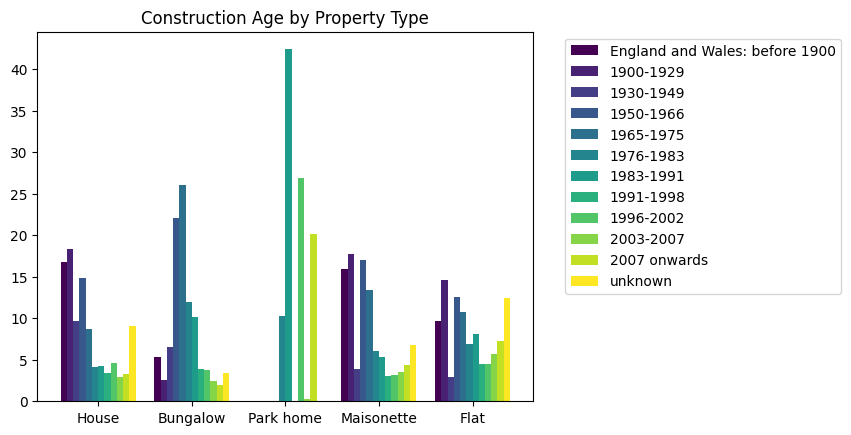

In [35]:
easy_plotting.plot_subcats_by_other_subcats(
    wales_epc_with_MCS_dates,
    "PROPERTY_TYPE",
    "CONSTRUCTION_AGE_BAND",
    plotting_colors="viridis",
    legend_loc="outside",
    plot_title="Construction Age by Property Type",
    fig_save_path=PROJECT_DIR / base_config.FIG_PATH
)

## Supplementary data

Most supplementary data is small enough that it can be loaded from S3 directly if needed, but you can also download all of it to a local dir.

In [36]:
imd_df = imd_data.get_imd_data(data_path='S3')
imd_df["Country"].value_counts()

England     2188612
Scotland     157832
Wales        138112
Name: Country, dtype: int64

In [37]:
imd_data.get_imd_data('Wales', data_path="S3")

,Postcode,IMD Rank,IMD Decile,Income Score,Employment Score,Country
0,CF11AA,426,3,32.0,14.4,Wales
1,CF11AB,426,3,32.0,14.4,Wales
2,CF11BU,426,3,32.0,14.4,Wales
3,CF17AT,426,3,32.0,14.4,Wales
4,CF17HR,426,3,32.0,14.4,Wales
...,...,...,...,...,...,...
138107,SY256WS,765,5,15.4,20.5,Wales
138108,SY256WW,765,5,15.4,20.5,Wales
138109,SY256WX,765,5,15.4,20.5,Wales
138110,SY256WZ,765,5,15.4,20.5,Wales


In [38]:
coords = coordinates.get_postcode_coordinates()
coords.head()

,POSTCODE,LATITUDE,LONGITUDE
0,AB10 1XG,57.144165,-2.114848
1,AB10 6RN,57.137880,-2.121487
2,AB10 7JB,57.124274,-2.127190
3,AB11 5QN,57.142701,-2.093295
4,AB11 6UL,57.137547,-2.112233


In [39]:
coords = data_cleaning.reformat_postcode(coords, white_space='add')
coords.head()

,POSTCODE,LATITUDE,LONGITUDE
0,AB10 1XG,57.144165,-2.114848
1,AB10 6RN,57.137880,-2.121487
2,AB10 7JB,57.124274,-2.127190
3,AB11 5QN,57.142701,-2.093295
4,AB11 6UL,57.137547,-2.112233


In [40]:
wales_epc_reduced_w_coords = feature_engineering.get_postcode_coordinates(wales_epc_reduced)
wales_epc_reduced_w_coords[['CURRENT_ENERGY_RATING', 'POSTCODE', 'LONGITUDE', 'LATITUDE']].head()

,CURRENT_ENERGY_RATING,POSTCODE,LONGITUDE,LATITUDE
0,C,NP75DX,-3.022069,51.82172
1,B,NP75DX,-3.022069,51.82172
2,B,NP75DX,-3.022069,51.82172
3,B,NP75DX,-3.022069,51.82172
4,C,NP75DX,-3.022069,51.82172


## EST cleansed version

This data is probably no longer needed but could be loaded as follows.
They are very large files and it would be hard to read it directly from S3.

In [41]:
data_getters.download_core_data('EST_cleansed_dedupl', LOCAL_DATA_DIR)

In [42]:
est_cleansed = epc_data.load_cleansed_epc(data_path=LOCAL_DATA_DIR, n_samples=500)
est_cleansed.columns

Loading cleansed EPC data... This will take a moment.


Index(['ROW_NUM', 'LMK_KEY', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3', 'POSTCODE',
       'BUILDING_REFERENCE_NUMBER', 'LOCAL_AUTHORITY', 'LOCAL_AUTHORITY_LABEL',
       'CONSTITUENCY', 'COUNTY', 'LODGEMENT_DATE', 'FINAL_PROPERTY_TYPE',
       'FINAL_PROP_TENURE', 'FINAL_PROPERTY_AGE', 'FINAL_HAB_ROOMS',
       'FINAL_FLOOR_AREA', 'FINAL_WALL_TYPE', 'FINAL_WALL_INS', 'FINAL_RIR',
       'FINAL_LOFT_INS', 'FINAL_ROOF_TYPE', 'FINAL_MAIN_FUEL',
       'FINAL_SEC_SYSTEM', 'FINAL_SEC_FUEL_TYPE', 'FINAL_GLAZ_TYPE',
       'FINAL_ENERGY_CONSUMPTION', 'FINAL_EPC_BAND', 'FINAL_EPC_SCORE',
       'FINAL_CO2_EMISSIONS', 'FINAL_FUEL_BILL', 'FINAL_METER_TYPE',
       'FINAL_FLOOR_TYPE', 'FINAL_FLOOR_INS', 'FINAL_HEAT_CONTROL',
       'FINAL_LOW_ENERGY_LIGHTING', 'FINAL_FIREPLACES', 'FINAL_WIND_FLAG',
       'FINAL_PV_FLAG', 'FINAL_SOLAR_THERMAL_FLAG', 'FINAL_MAIN_FUEL_NEW',
       'FINAL_HEATING_SYSTEM', 'HEAT_PUMP'],
      dtype='object')